`Дисциплина: Методы и технологии машинного обучения`   
`Уровень подготовки: бакалавриат`   
`Направление подготовки: 01.03.02 Прикладная математика и информатика`   





# Парсинг сайтов и анализ текстовой информации

### Работу выполнила Бобина Татьяна Сергеевна
Данные: раздел красота и здоровье на сайте https://irecommend.ru/catalog/list/6

### Загрузка пакетов

In [13]:
import re
import nltk
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import sleep
from random import randint
import pymorphy2
from bs4 import BeautifulSoup
from wordcloud import WordCloud
from sklearn.manifold import TSNE
from nltk.corpus import stopwords
from sklearn.cluster import KMeans
from nltk.probability import FreqDist
from sklearn.decomposition import PCA
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\4793788\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [14]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\4793788\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Загрузка и проверка данных

In [25]:
count_pages = 30
products_per_page = 20

# Список для хранения информации о товарах 
products_info = []

# Проходим по каждой странице 
for page_num in range(0, count_pages):
    url = f'https://irecommend.ru/catalog/list/6?page={page_num}'
    r = requests.get(url)
    soup = BeautifulSoup(r.content, 'html.parser')
    
    products = soup.find_all('div', class_='ProductTizer plate teaser-item')
    
    for product in products:
        title = product.find('div', class_='title').text
        mean_rating = product.find('span', class_='average-rating').find('span').text
        products_info.append((title, mean_rating))
        
    print(f'{page_num+1}✓', end=' ')
    sleep(randint(8, 11))
    

1✓ 2✓ 3✓ 4✓ 5✓ 6✓ 7✓ 8✓ 9✓ 10✓ 11✓ 12✓ 13✓ 14✓ 15✓ 16✓ 17✓ 18✓ 19✓ 20✓ 21✓ 22✓ 23✓ 24✓ 25✓ 26✓ 27✓ 28✓ 29✓ 30✓ 

In [26]:
if len(products_info) == count_pages*products_per_page:
    print('All elements are parsed')
    df = pd.DataFrame(products_info, columns=['title', 'mean_rating'])
else:
    print('Something went wrong, count of products_info less or more than expected')

All elements are parsed


In [28]:
df

,title,mean_rating
0,Масло после бритья Ecolatier Organic Cactus Гл...,4.7
1,Крем для лица ART&FACT. увлажняющий с низкомол...,4.3
2,Парфюмированный спрей для тела Avon Little Bla...,4.5
3,Тканевая маска для лица Eyenlip Super Food Avo...,4
4,Дезодорант-антиперспирант DRY RU FORTE PLUS ...,3.1
...,...,...
595,Шампунь от выпадения волос Alerana PH - Увлажн...,4
596,Фитбол мяч для фитнеса Atlas Фитбол,5
597,Капсулы Омега 3 DO4A LAB OMEGA 3,2
598,Antonio Banderas Her Golden Secret,4.5


### Первичный анализ данных

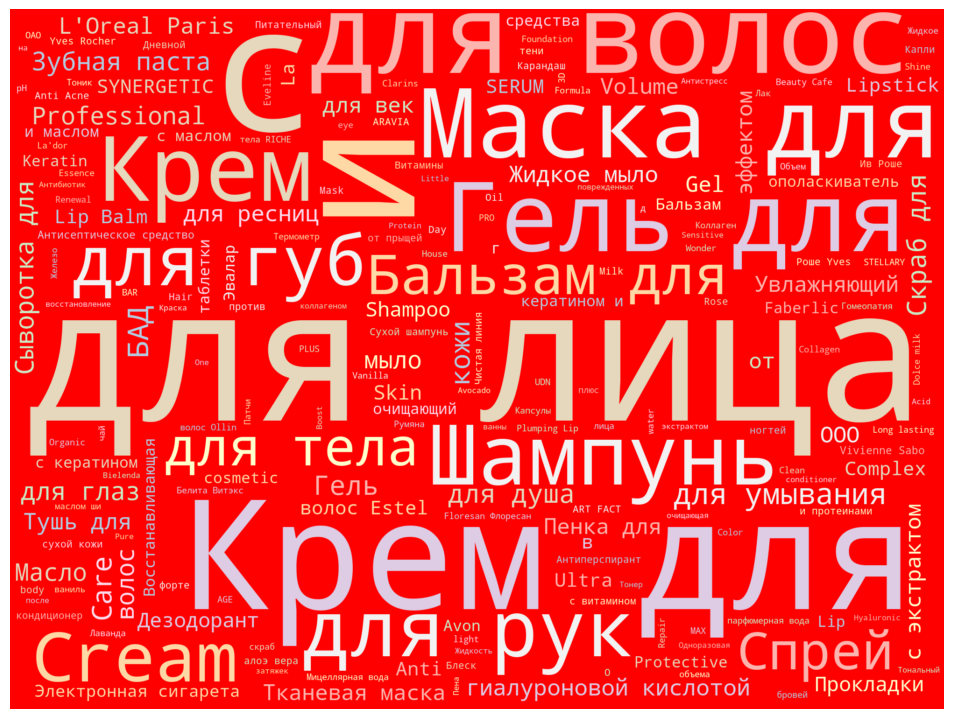

In [31]:
wordcloud = WordCloud(width=2000, height=1500, background_color='red',
                      colormap='Pastel1', min_font_size=15, margin=15).generate(' '.join(df['title']))

plt.figure(figsize=(15, 7), facecolor=None)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

Можно заметить насколько часто используется слово "для" или поменьше "с" и "от" в названиях товаров. Необходимо привести данные к нижнему регистру, почистить от стоп-слов, знаков препинания, одиночных чисел и символов и привести к нормальной форме.

### Обработка данных

In [32]:
morph = pymorphy2.MorphAnalyzer()
stop_words = stopwords.words("russian")

def clean_title_lemmatize(title):
    title = title.lower()
    title = re.sub(r'[^\w\s]', '', title)
    title = re.sub(r'\b\d+\b', '', title)
    title = re.sub(r'\b\w{1,2}\b', '', title)
    words = word_tokenize(title)
    words = [word for word in words if word not in stop_words]
    title = ' '.join(words)
    lemmas = [morph.parse(word)[0].normal_form for word in words]
    return ' '.join(lemmas)

In [33]:
df['title'] = df['title'].apply(clean_title_lemmatize)

In [34]:
df

,title,mean_rating
0,масло бритьё ecolatier organic cactus гладкост...,4.7
1,крем лицо artfact увлажнять низкомолекулярный ...,4.3
2,парфюмировать спреть тело avon little black dress,4.5
3,тканевый маска лицо eyenlip super food avocado,4
4,дезодорантантиперспирант dry forte plus усилен...,3.1
...,...,...
595,шампунь выпадение волос alerana увлажнять,4
596,фитбол мяч фитнес atlas фитбол,5
597,капсула омега do4a lab omega,2
598,antonio banderas her golden secret,4.5


### Анализ после обработки

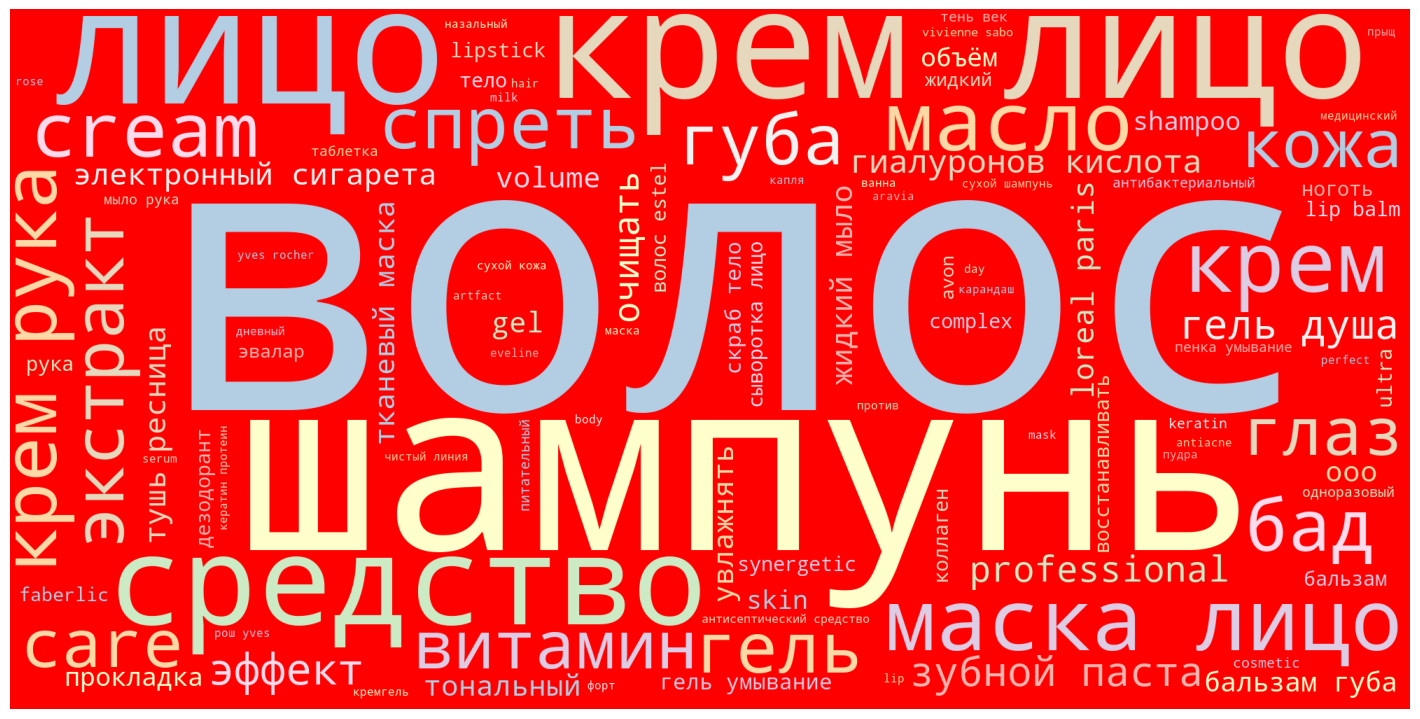

In [36]:
wordcloud = WordCloud(width=2000, height=1000, background_color='red',
                      colormap='Pastel1', min_font_size=15, margin=15).generate(' '.join(df['title']))

plt.figure(figsize=(15, 7), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

Мы обработали текст и выделили наиболее часто встречающиеся темы, которые относятся к разделу Красота и здоровье. Среди них можно выделить декоративную косметику, уходовая косметика, а также средства личной гигиены. Также видно, что удалились ненужные частицы. 

### Частотный анализ слов

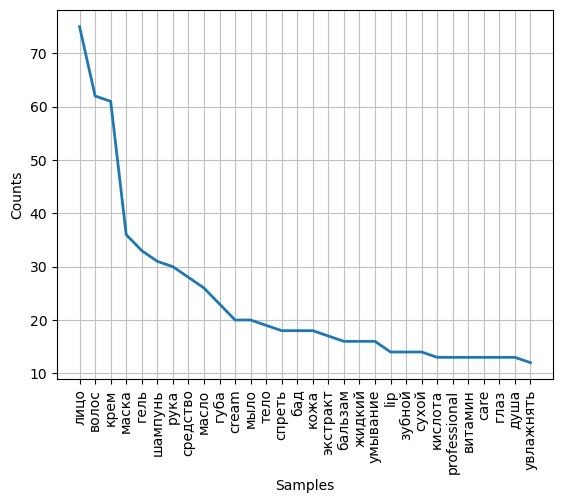

In [38]:
fdist = FreqDist()

for title in df['title']:
    for word in title.split():
        fdist[word] += 1

fdist.plot(30)
plt.show()

Разделение может быть произведено по:
+ Уход за лицом
+ Уход за кожей
+ Уход за волосами
+ Уход за телом
+ Декоративная косметика
+ Витамины
+ Зубная гигиена

### Разделение с помощью TfidVectorizer и CountVectorizer

In [39]:
titles = df['title']

tfidf_vectorizer = TfidfVectorizer()
tfidf_vectors = tfidf_vectorizer.fit_transform(df['title'])

n_clusters = 10
tfidf_kmeans = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=100, n_init=1)
tfidf_clusters = tfidf_kmeans.fit_predict(tfidf_vectors)

for i in range(n_clusters):
    print(f"Cluster {i+1}:")
    print(titles[tfidf_clusters == i])
    print()

Cluster 1:
2      парфюмировать спреть тело avon little black dress
4      дезодорантантиперспирант dry forte plus усилен...
7                                         кефирный диета
8              бритвенный станок bic twin lady sensitive
9          лак эффект гель jeanmishel gel efftect ноготь
                             ...                        
594        назальный спреть bouchara recordati полидекса
596                       фитбол мяч фитнес atlas фитбол
597                         капсула омега do4a lab omega
598                   antonio banderas her golden secret
599    гель душа petit marseillais средиземноморский ...
Name: title, Length: 327, dtype: object

Cluster 2:
30     жидкость электронный сигарета rell pina colada...
38     одноразовый электронный сигарета randm tornado...
87         электронный сигарета voopoo vthru pro pod kit
188                     электронный сигарета izi tyt max
338    термометр bwell медицинский электронный base с...
352    термометр bwell ме

In [40]:
count_vectorizer = CountVectorizer()
count_vectors = count_vectorizer.fit_transform(titles)

count_kmeans = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=100, n_init=1)
count_clusters = count_kmeans.fit_predict(count_vectors)

for i in range(n_clusters):
    print(f"Cluster {i+1}:")
    print(titles[count_clusters == i])
    print()

Cluster 1:
497    средство промывание орошение полость нос ооо л...
577               комплекс промывание нос dolphin долфин
Name: title, dtype: object

Cluster 2:
249    нейролептик антипсихотический средство канонфа...
328    нейролептик антипсихотический средство канонфа...
344    нейролептик антипсихотический средство канонфа...
Name: title, dtype: object

Cluster 3:
17                               спреть волос estel plus
19                                 маска волос estel тон
46                               пена ванна estel little
68                               пена ванна estel little
136       маска волос synergetic тонизировать рост волос
137     маска окрасить волос k18 biomimetric hairscience
139                         маска волос bioaqua имбирный
217      пудра обесцвечивание волос estel princess essex
230                 кремкраска волос estel prince chrome
237            маска волос lador eco hydro lpp treatment
255                          шампунь estel versus winter

TfidfVectorizer в большинстве случаях всегда будет давать более хорошие результаты, так как он учитывает не только частоту слов, но и их важность в тексте. 
Примерные его группы разбиения:

+ В первый кластер, скорее всего, попали все товары, которые содержат названия на английском
+ Электронные сигареты
+ Уход за лицом
+ Жидкое мыло
+ Зубная паста
+ Средства личной гигиены
+ Уход за волосами
+ Уход за телом
+ Декоративная косметика
+ Витамины


### Визуализация разбиения

In [41]:
def make_cooccurrence_matrix(texts):
  # Зададим словарь и попарную частоту совместной встречаемости слов
  vocabulary = set(texts[0].split())
  for t in texts[1:]:
    vocabulary = vocabulary.union(set(t.split()))
  vocabulary=list(vocabulary)

  N = len(vocabulary)
  
  # Задаём cooccurrence matrix
  cooccurrence = np.zeros((N,N))
  for i in range(N):
    for j in range(i, N):
      if i == j:
        continue
      for t in texts:
        if vocabulary[i] in t.split() and vocabulary[j] in t.split():
          cooccurrence[i][j]+=1
          cooccurrence[j][i]+=1
  return cooccurrence, vocabulary

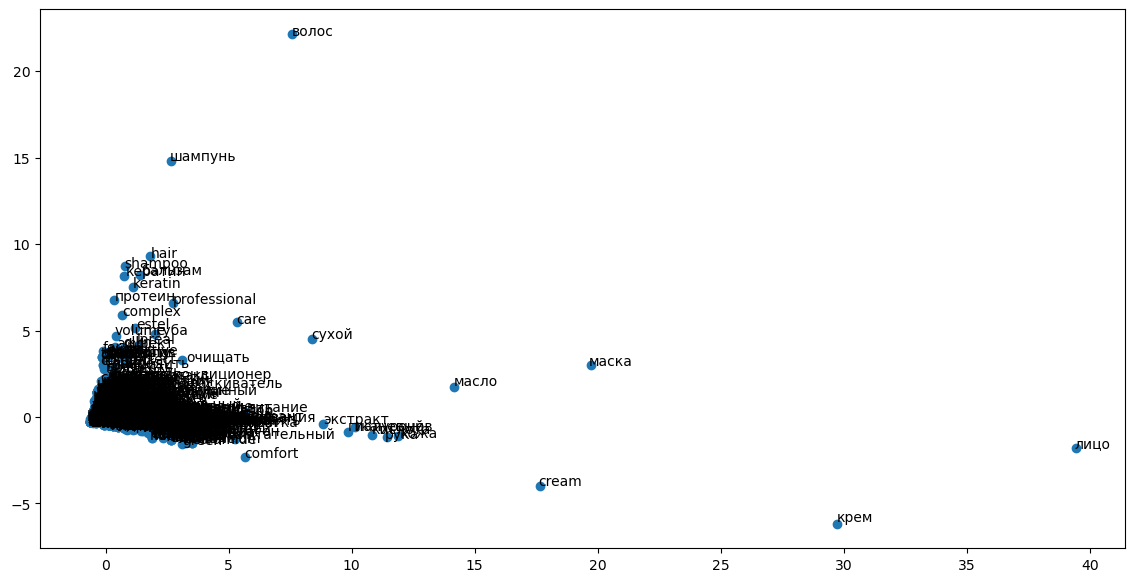

In [43]:
text_list = df['title'].tolist()

c, v = make_cooccurrence_matrix(text_list)

p = PCA(n_components=2)
pca = p.fit_transform(c)

plt.figure(figsize=(14,7))
ax = plt.gca()
for i, c in enumerate(pca):
    ax.annotate(text = v[i], xy = (c[0] + np.random.randn()/15, c[1]+ np.random.randn()/15))
plt.scatter(pca[:,0], pca[:,1])
plt.show()

C:\Users\4793788\anaconda3\envs\SamRab3\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\4793788\anaconda3\envs\SamRab3\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


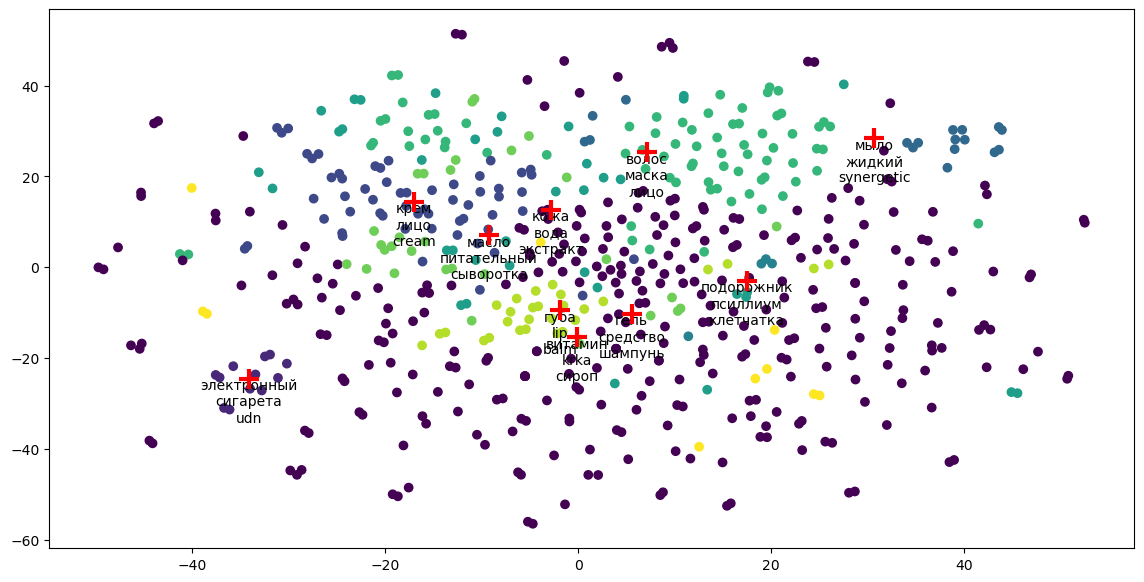

In [44]:
tsne = TSNE(n_components=2)
reduced_vectors = tsne.fit_transform(tfidf_vectors.toarray())

centroids = np.zeros((n_clusters, 2))
for i in range(n_clusters):
    centroids[i] = np.mean(reduced_vectors[tfidf_clusters == i], axis=0)

plt.figure(figsize=(14, 7))
plt.scatter(reduced_vectors[:, 0], reduced_vectors[:, 1], c=tfidf_clusters)
plt.scatter(centroids[:, 0], centroids[:, 1], marker='+', s=200, linewidths=3, color='r', zorder=10)

for i in range(n_clusters):
    cluster_words = tfidf_vectors[tfidf_clusters == i].toarray().sum(axis=0)
    top_words_indices = cluster_words.argsort()[-3:][::-1]
    top_words = [tfidf_vectorizer.get_feature_names_out()[index] for index in top_words_indices]
    plt.annotate('\n'.join(top_words), (centroids[i, 0], centroids[i, 1]), ha='center', va='top')

plt.show()

### Подсчёт характеристик

In [45]:
df['mean_rating'] = df['mean_rating'].astype(float)

df['cluster'] = tfidf_clusters

In [46]:
title_count = df.groupby('cluster')['title'].count()
sum_mean_rating = df.groupby('cluster')['mean_rating'].sum()
mean_rating = df.groupby('cluster')['mean_rating'].mean()

stats_df = pd.concat([title_count, sum_mean_rating, mean_rating], axis=1)
stats_df.columns = ['title_count', 'sum_mean_rating', 'mean_rating']

stats_df

,title_count,sum_mean_rating,mean_rating
cluster,,,
0,327,1422.5,4.350153
1,12,46.6,3.883333
2,58,248.2,4.279310
3,17,81.6,4.800000
4,4,17.3,4.325000
5,37,155.5,4.202703
6,77,326.7,4.242857
7,30,129.0,4.300000
8,28,118.7,4.239286


Анализируя данную таблицу, можно сделать вывод, что товары из 0-го кластера, в которых присутствуют названия на иностранном языке, пользуются наибольшей популярностью среди пользователей, товары из 6-го кластера, связанные с уходом за волосами, также пользуются популярностью среди пользователей, на третьем месте по популярности идут товары из 2-го кластера, связанные с уходом для лица. Мы видим, что кластеры 5 (средства личной гигиены) и 7 (уход за телом) имеют меньшее количество отзывов, что может говорить о более узкой аудитории потребителей. Остальные кластеры имеют еще меньшее количество отзывов, что говорит о том, что данные товары пользуются меньшей популярностью или имеют более узкую целевую аудиторию. Лучшими товарами можем считать товары из кластара 3 (жидкое мыло), так как у него наиболее высокое значение среднего рейтинга (4.8), наименее высокая оценка у 1-го кластера (электронные сигареты), что говорит о менее хорошем качестве товаров.